In [73]:
import numpy as np
from sklearn.metrics import classification_report, recall_score, precision_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, scale
from sklearn.cross_validation import train_test_split

import pandas as pd
from pickle import load, dump

from keras import metrics
import keras.backend as K
from keras.layers import *
from keras.layers.core import *
from keras.layers.recurrent import *
from keras.layers.merge import *
from keras.layers.convolutional import *
from keras.layers.embeddings import *
from keras.layers.wrappers import *
from keras.layers.normalization import *
from keras.layers.advanced_activations import *
from keras.models import *
from keras.callbacks import *
from keras.utils.vis_utils import *
from keras.utils import *

from IPython.display import SVG
import matplotlib.pyplot as plt

In [74]:
def read_data(path):
    Xs, Ys = pd.read_pickle(path)
    

    Xtrain, Xvalid, Xtest = Xs[:,:5725], Xs[:,5725:5725*2], Xs[:,5725*2:]
    
    Ys = np.concatenate([to_categorical(Ys[rowid])[None,:,:] for rowid in range(len(Ys))])
    Ytrain, Yvalid, Ytest = Ys[:,:5725], Ys[:,5725:5725*2], Ys[:,5725*2:]

    return Xtrain, Xvalid, Xtest, Ytrain, Yvalid, Ytest

In [75]:
Xtrain, Xvalid, Xtest, Ytrain, Yvalid, Ytest = read_data("../data/input.pkl")


In [76]:
print(f"train, X size: {Xtrain.shape}, Y size: {Ytrain.shape}")
print(f"test, X size: {Xvalid.shape}, Y size: {Yvalid.shape}")

train, X size: (2, 5725, 100, 5), Y size: (2, 5725, 2)
test, X size: (2, 5725, 100, 5), Y size: (2, 5725, 2)


In [77]:
scaler = StandardScaler()

In [78]:
Xtrain1 = scaler.fit_transform(Xtrain.reshape(-1, 500)).reshape(2, 5725, 100, 5)
Xvalid1 = scaler.transform(Xvalid.reshape(-1, 500)).reshape(2, 5725, 100, 5)

/home/wooya/.pyenv/versions/3.6.2/lib/python3.6/site-packages/sklearn/utils/validation.py:444: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [79]:
200*100

20000

In [82]:
def LSTM_bin(inputs, bname):
    tsteps = 100
    lstm_units = 100
    
    # LSTM
    out_lstm = Bidirectional(LSTM(lstm_units, return_sequences=True), name=bname)(inputs)
    # ATTENTION
    out_att = Permute((2, 1))(out_lstm)
    out_att = Dense(tsteps, activation='softmax')(out_att)
    out_att = Permute((2, 1), name='attention_vec'+bname)(out_att)
    out_att = Multiply(name='attention_mul'+bname)([out_lstm, out_att])
    out_att = Lambda(lambda x: K.sum(x, axis=1, keepdims=True))(out_att)
    return out_att

def LSTM_hm(inputs):
    tsteps = 5
    lstm_units = 200
    
    # LSTM
    out_lstm = Bidirectional(LSTM(lstm_units, return_sequences=True), name='hmlstm')(inputs)
    # ATTENTION
    out_att = Permute((2, 1))(out_lstm)
    out_att = Dense(tsteps, activation='softmax')(out_att)
    out_att = Permute((2, 1), name='attention_vec')(out_att)
    out_att = Multiply(name='attention_mul')([out_lstm, out_att])

    return out_att

lstm_units = 100
feats = 1
tsteps = 100

### construct model

# bin-level LSTM + Attention
inputs1 = Input(shape=(tsteps, feats))
out_att1 = LSTM_bin(inputs1, 'binlstm1')
inputs2 = Input(shape=(tsteps, feats))
out_att2 = LSTM_bin(inputs2, 'binlstm2')
inputs3 = Input(shape=(tsteps, feats))
out_att3 = LSTM_bin(inputs3, 'binlstm3')
inputs4 = Input(shape=(tsteps, feats))
out_att4 = LSTM_bin(inputs4, 'binlstm4')
inputs5 = Input(shape=(tsteps, feats))
out_att5 = LSTM_bin(inputs5, 'binlstm5')

# HM-level merge
mmerge = concatenate([out_att1, out_att2, out_att3, out_att4, out_att5], axis=1)

# HM-level LSTM
out_hmatt = LSTM_hm(mmerge)

# output layer
flat = Flatten()(out_hmatt)
output = Dense(2, activation='softmax')(flat)

model = Model(inputs=[inputs1, inputs2, inputs3, inputs4, inputs5], outputs=output )
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_90 (InputLayer)            (None, 100, 1)        0                                            
____________________________________________________________________________________________________
input_91 (InputLayer)            (None, 100, 1)        0                                            
____________________________________________________________________________________________________
input_92 (InputLayer)            (None, 100, 1)        0                                            
____________________________________________________________________________________________________
input_93 (InputLayer)            (None, 100, 1)        0                                            
___________________________________________________________________________________________

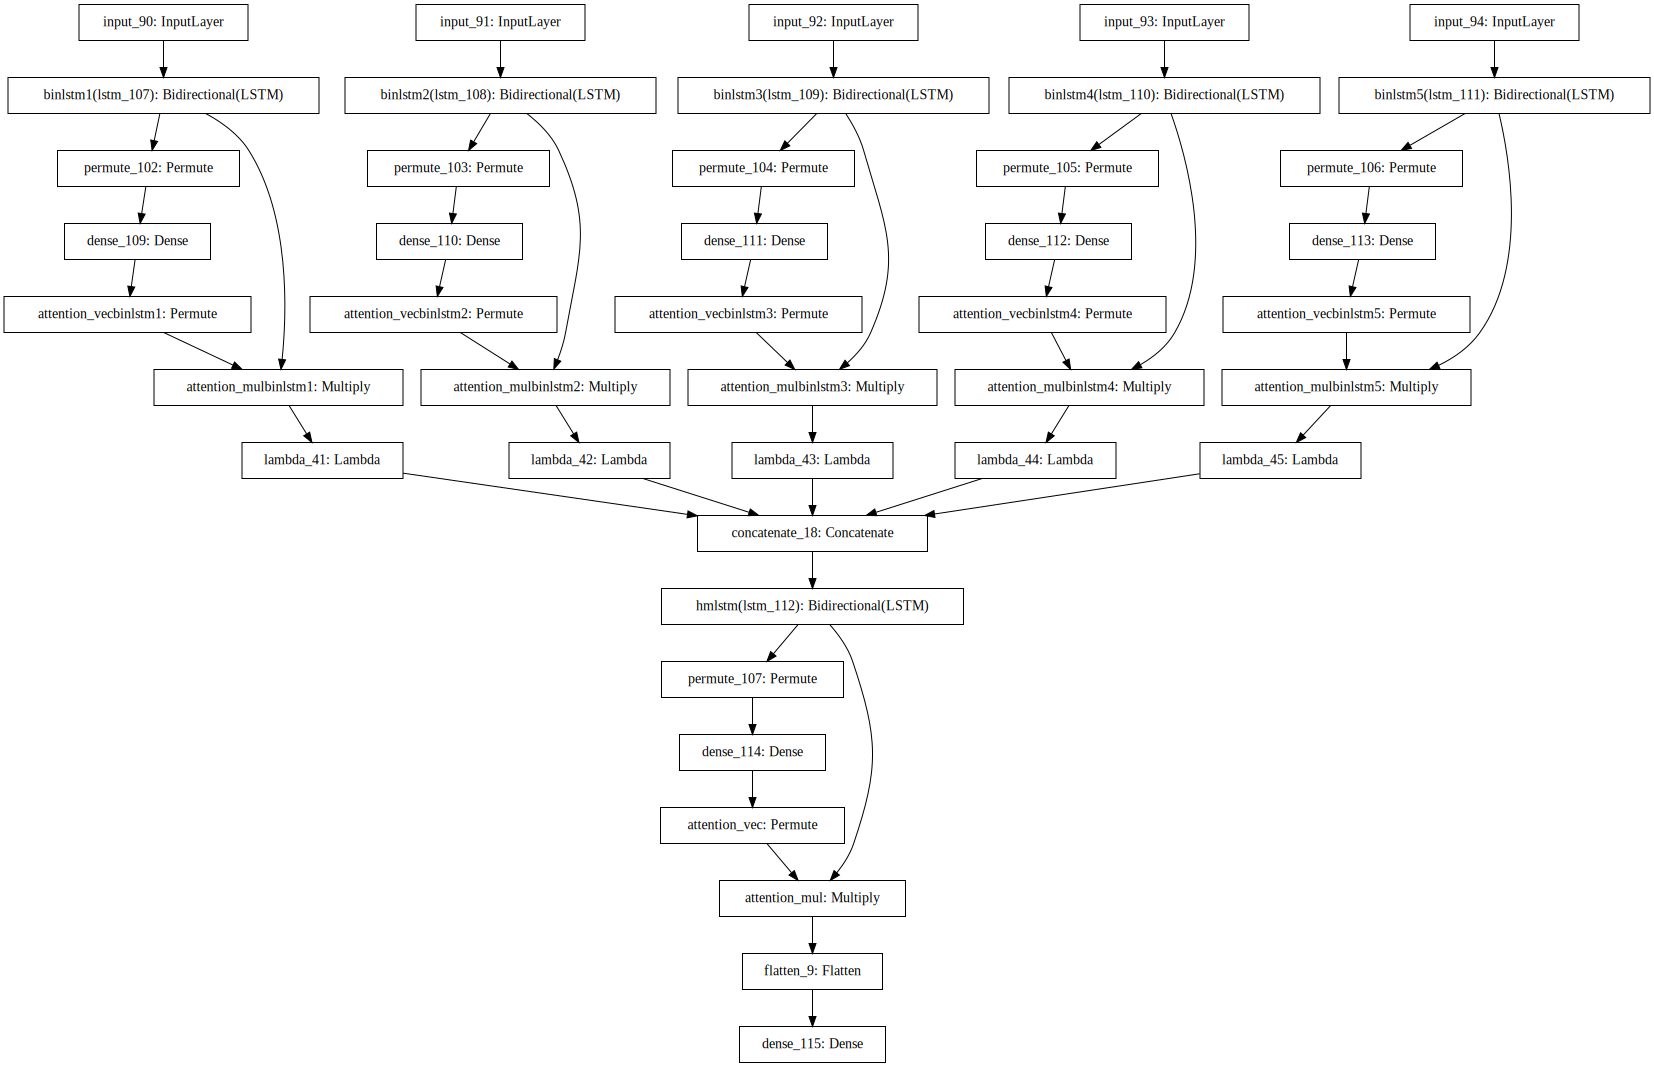

In [83]:
model.summary()
SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [ ]:
run_name = "attentive chrome real new E013 scale 2"
tb = TensorBoard(log_dir=f"../log/{run_name}", batch_size=32, write_graph=True)
checkpointer = ModelCheckpoint(filepath=f"../model/{run_name}.h5", verbose=1, save_best_only=True, monitor="val_acc")
stopper = EarlyStopping(monitor="val_acc", patience=3)

In [ ]:
epigenome = 0
a,b,c,d,e = np.swapaxes(np.swapaxes(Xtrain1[epigenome], 0, 2), 1, 2)[:,:,:,None]
va,vb,vc,vd,ve = np.swapaxes(np.swapaxes(Xvalid1[epigenome], 0, 2), 1, 2)[:,:,:,None]

model.fit(
    [a,b,c,d,e],
    Ytrain[epigenome],
    batch_size=4000,
    callbacks = [tb, checkpointer],
    epochs=1000,
    shuffle=True,
    validation_data=([va,vb,vc,vd,ve], Yvalid[epigenome]),
    verbose=0)